# Character Scene Composition with Image-to-Image Conversion
=====================================================

This notebook demonstrates how to create a composite character scene by:
1. Creating a blank white canvas as background
2. Placing character placeholder images on the canvas
3. Using Stable Diffusion image-to-image conversion to transform character images
4. Seamlessly integrating the converted characters into the scene using inpainting.

## Import the necessary libraries

In [1]:
# Core imports
import torch
import numpy as np
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

# Image processing
from PIL import Image, ImageDraw, ImageOps, ImageFilter
import requests

# Diffusion models
from diffusers import (
    StableDiffusionInpaintPipeline,
    StableDiffusionImg2ImgPipeline,
    AutoPipelineForInpainting
)

# AI Upscaling with Hugging Face models
try:
    from transformers import AutoImageProcessor, AutoModelForImage2Image
    import torch.nn.functional as F
    AI_UPSCALING_AVAILABLE = True
    print("✅ Hugging Face AI upscaling available")
except ImportError:
    AI_UPSCALING_AVAILABLE = False
    print("⚠️ Hugging Face upscaling not available - using basic upscaling")
    print("Install with: pip install transformers")

⚠️ Hugging Face upscaling not available - using basic upscaling
Install with: pip install transformers


In [2]:
# Core imports
import torch
import numpy as np
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

# Image processing
from PIL import Image, ImageDraw, ImageOps, ImageFilter
import requests

# Diffusion models
from diffusers import (
    StableDiffusionInpaintPipeline,
    StableDiffusionImg2ImgPipeline,
    AutoPipelineForInpainting
)

## Device Setup

In [3]:
def setup_device():
    """Setup optimal device for diffusion models."""
    if torch.cuda.is_available():
        return "cuda", torch.float16
    elif torch.backends.mps.is_available():
        return "mps", torch.float32
    else:
        return "cpu", torch.float32

# Setup device
device, dtype = setup_device()
print(f"Using device: {device} with dtype: {dtype}")

Using device: mps with dtype: torch.float32


## Load Diffusion Pipelines

In [4]:
def load_pipelines(device="cuda", dtype=torch.float16):
    """Load both inpainting and img2img pipelines."""
    
    # Load inpainting pipeline
    print("Loading inpainting pipeline...")
    inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "Lykon/dreamshaper-8-inpainting",
        torch_dtype=dtype,
        safety_checker=None,
        requires_safety_checker=False
    )
    inpaint_pipe = inpaint_pipe.to(device)
    
    if hasattr(inpaint_pipe, 'enable_attention_slicing'):
        inpaint_pipe.enable_attention_slicing()
    
    # Load img2img pipeline
    print("Loading img2img pipeline...")
    img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=dtype,
        safety_checker=None,
        requires_safety_checker=False
    )
    img2img_pipe = img2img_pipe.to(device)
    
    if hasattr(img2img_pipe, 'enable_attention_slicing'):
        img2img_pipe.enable_attention_slicing()
    
    return inpaint_pipe, img2img_pipe

# Load pipelines
inpaint_pipe, img2img_pipe = load_pipelines(device, dtype)
print("All pipelines loaded successfully!")

Loading inpainting pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/sudipta/Workspace/Learning/AI-Course/gen-ai-examples/.venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Loading img2img pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

All pipelines loaded successfully!


## Image Loading and Processing Functions

Loading character images...


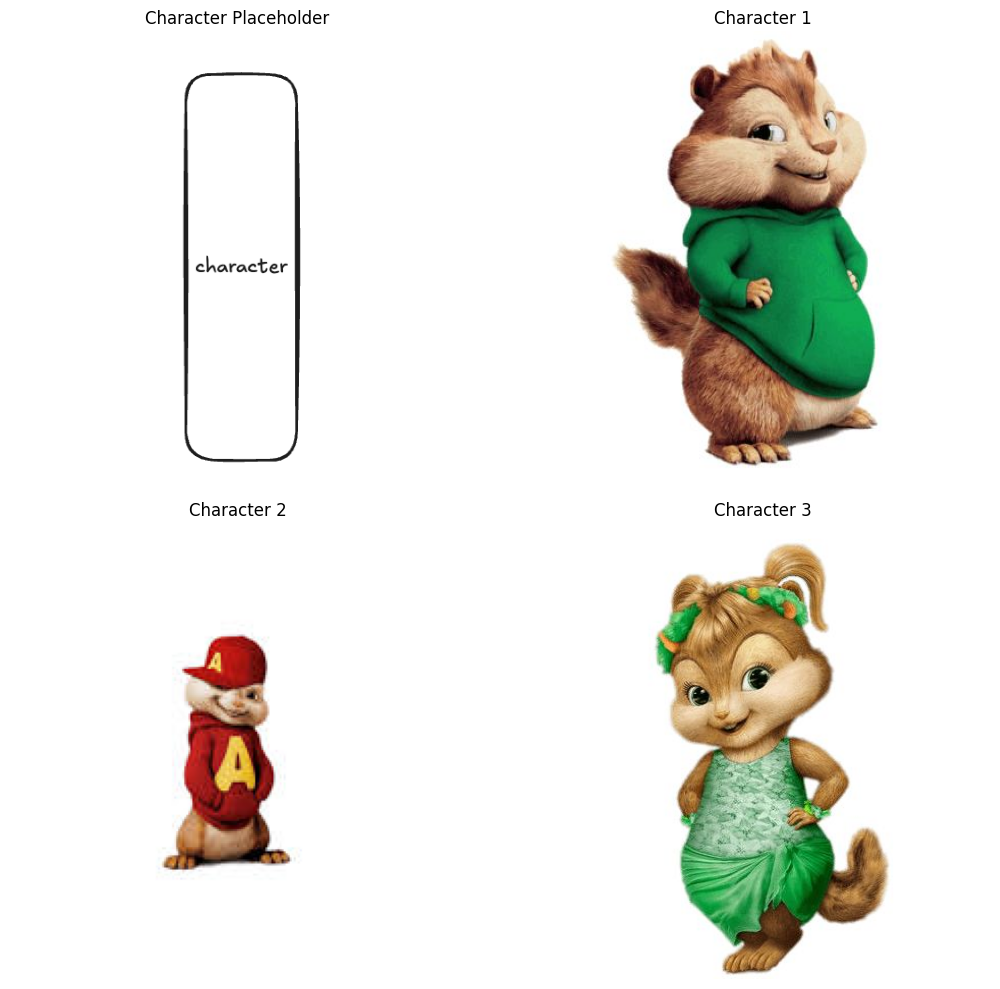

In [5]:
def load_image_from_path(path: str) -> Image.Image:
    """Load an image from a local file path."""
    try:
        image = Image.open(path)
        return image
    except Exception as e:
        print(f"Error loading image from path: {e}")
        raise

def resize_image_maintain_aspect(image: Image.Image, target_size: Tuple[int, int]) -> Image.Image:
    """Resize image while maintaining aspect ratio and padding if necessary."""
    target_width, target_height = target_size
    img_width, img_height = image.size
    
    # Calculate scaling factor to fit within target size
    scale = min(target_width / img_width, target_height / img_height)
    new_width = int(img_width * scale)
    new_height = int(img_height * scale)
    
    # Resize image
    resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create new image with target size and paste resized image in center
    result = Image.new('RGBA', target_size, (0, 0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    result.paste(resized, (paste_x, paste_y))
    
    return result

def create_white_canvas(size: Tuple[int, int] = (1024, 768)) -> Image.Image:
    """Create a blank white canvas."""
    return Image.new('RGB', size, (255, 255, 255))

# Load character images
print("Loading character images...")
char_placeholder = load_image_from_path("assets/char-placeholder.png")
ch1 = load_image_from_path("assets/ch1.png")
ch2 = load_image_from_path("assets/ch2.png")
ch3 = load_image_from_path("assets/ch3.png")

# Display the character images
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(char_placeholder)
axes[0, 0].set_title("Character Placeholder")
axes[0, 0].axis('off')

axes[0, 1].imshow(ch1)
axes[0, 1].set_title("Character 1")
axes[0, 1].axis('off')

axes[1, 0].imshow(ch2)
axes[1, 0].set_title("Character 2")
axes[1, 0].axis('off')

axes[1, 1].imshow(ch3)
axes[1, 1].set_title("Character 3")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Create White Canvas with Character Placeholders

Creating white canvas with character placeholders...


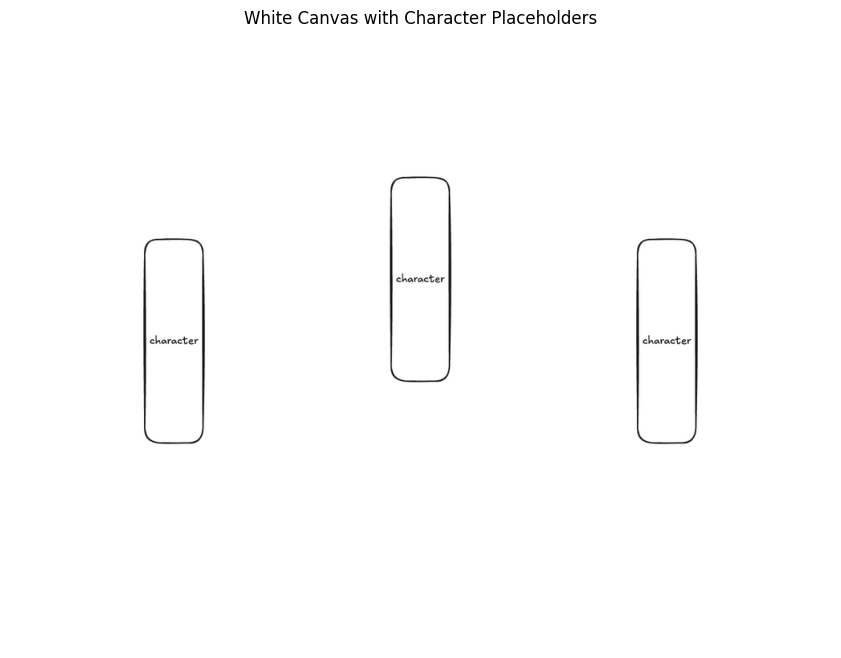

Character positions: [(102, 230), (409, 153), (716, 230)]
Character bounding boxes: [(102, 230, 302, 530), (409, 153, 609, 453), (716, 230, 916, 530)]


In [6]:
def create_canvas_with_placeholders(canvas_size: Tuple[int, int] = (1024, 768), 
                                   char_size: Tuple[int, int] = (200, 300)):
    """Create a white canvas with 3 character placeholders positioned."""
    
    # Create white canvas
    canvas = create_white_canvas(canvas_size)
    
    # Define positions for 3 characters (left, center, right)
    positions = [
        (int(canvas_size[0] * 0.1), int(canvas_size[1] * 0.3)),   # Left character
        (int(canvas_size[0] * 0.4), int(canvas_size[1] * 0.2)),   # Center character
        (int(canvas_size[0] * 0.7), int(canvas_size[1] * 0.3))    # Right character
    ]
    
    # Resize placeholder to target size
    placeholder_resized = resize_image_maintain_aspect(char_placeholder, char_size)
    
    # Create bounding boxes for each character position
    char_bboxes = []
    
    for i, (x, y) in enumerate(positions):
        # Paste placeholder
        canvas.paste(placeholder_resized, (x, y), placeholder_resized)
        
        # Store bounding box
        bbox = (x, y, x + char_size[0], y + char_size[1])
        char_bboxes.append(bbox)
    
    return canvas, char_bboxes, positions

# Create canvas with placeholders
print("Creating white canvas with character placeholders...")
canvas, char_bboxes, positions = create_canvas_with_placeholders()

# Display the canvas
plt.figure(figsize=(12, 8))
plt.imshow(canvas)
plt.title("White Canvas with Character Placeholders")
plt.axis('off')
plt.show()

print(f"Character positions: {positions}")
print(f"Character bounding boxes: {char_bboxes}")

In [7]:
def setup_ai_upscaler():
    """Setup AI-powered upscaler using Hugging Face models."""
    if not AI_UPSCALING_AVAILABLE:
        return None, None
    
    try:
        # Use Swin2SR model for high-quality upscaling
        model_name = "caidas/swin2SR-realworld-sr-x4-64-bsrgan-psnr"
        print(f"Loading AI upscaling model: {model_name}")
        
        processor = AutoImageProcessor.from_pretrained(model_name)
        model = AutoModelForImage2Image.from_pretrained(model_name)
        model.to(device)
        
        print("✅ AI upscaling model loaded successfully!")
        return processor, model
    except Exception as e:
        print(f"⚠️ Failed to load AI upscaling model: {e}")
        return None, None

def upscale_image(image: Image.Image, scale_factor: float = 2.0, use_ai: bool = True) -> Image.Image:
    """Upscale image using AI-powered upscaling or basic resampling."""
    
    if use_ai and AI_UPSCALING_AVAILABLE:
        try:
            processor, model = setup_ai_upscaler()
            if processor is not None and model is not None:
                # Convert PIL to tensor
                inputs = processor(image, return_tensors="pt")
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # Generate upscaled image
                with torch.no_grad():
                    outputs = model(**inputs)
                    upscaled_tensor = outputs.reconstruction
                
                # Convert back to PIL
                upscaled_image = processor.image_processor.postprocess(
                    upscaled_tensor, output_type="pil"
                )[0]
                
                # Resize to target scale if needed (most models are 4x upscalers)
                if scale_factor != 4.0:
                    target_width = int(image.size[0] * scale_factor)
                    target_height = int(image.size[1] * scale_factor)
                    upscaled_image = upscaled_image.resize((target_width, target_height), Image.Resampling.LANCZOS)
                
                return upscaled_image
        except Exception as e:
            print(f"⚠️ AI upscaling failed: {e}, falling back to basic upscaling")
    
    # Fallback to basic upscaling
    new_width = int(image.size[0] * scale_factor)
    new_height = int(image.size[1] * scale_factor)
    return image.resize((new_width, new_height), Image.Resampling.LANCZOS)

def convert_character_with_img2img(pipe, character_image: Image.Image, 
                                  prompt: str, strength: float = 0.75, 
                                  guidance_scale: float = 7.5, seed: int = 42,
                                  apply_ai_upscaling: bool = True) -> Image.Image:
    """Convert a character image using Stable Diffusion img2img with higher resolution and AI upscaling."""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # Use higher resolution for better quality (768x768 instead of 512x512)
    process_size = (768, 768)
    image_resized = character_image.resize(process_size, Image.Resampling.LANCZOS)
    
    with torch.no_grad():
        result = pipe(
            prompt=prompt,
            image=image_resized,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=30,  # Increased steps for better quality
            eta=0.0  # Deterministic sampling
        )
    
    # Get the generated image
    result_image = result.images[0]
    
    # Apply AI upscaling to the generated result for better quality
    if apply_ai_upscaling:
        print("  Applying AI upscaling to generated image...")
        result_image = upscale_image(result_image, scale_factor=1.5, use_ai=True)
    
    # Resize back to original size with high quality
    result_image = result_image.resize(character_image.size, Image.Resampling.LANCZOS)
    
    return result_image

def create_mask_for_character(image: Image.Image, bbox: Tuple[int, int, int, int], 
                             feather_radius: int = 10) -> Image.Image:
    """Create a mask for character replacement."""
    mask = Image.new("L", image.size, 0)
    draw = ImageDraw.Draw(mask)
    
    # Add some padding around the bbox for smooth blending
    left, top, right, bottom = bbox
    padding = feather_radius
    expanded_bbox = (
        max(0, left - padding),
        max(0, top - padding),
        min(image.size[0], right + padding),
        min(image.size[1], bottom + padding)
    )
    
    draw.rectangle(expanded_bbox, fill=255)
    
    # Apply feathering for smooth edges
    if feather_radius > 0:
        mask = mask.filter(ImageFilter.GaussianBlur(radius=feather_radius))
    
    return mask

Converting characters with img2img + automatic AI upscaling...
Converting character 1...


  0%|          | 0/19 [00:00<?, ?it/s]

  Applying AI upscaling to generated image...
Converting character 2...


  0%|          | 0/19 [00:00<?, ?it/s]

  Applying AI upscaling to generated image...
Converting character 3...


  0%|          | 0/19 [00:00<?, ?it/s]

  Applying AI upscaling to generated image...


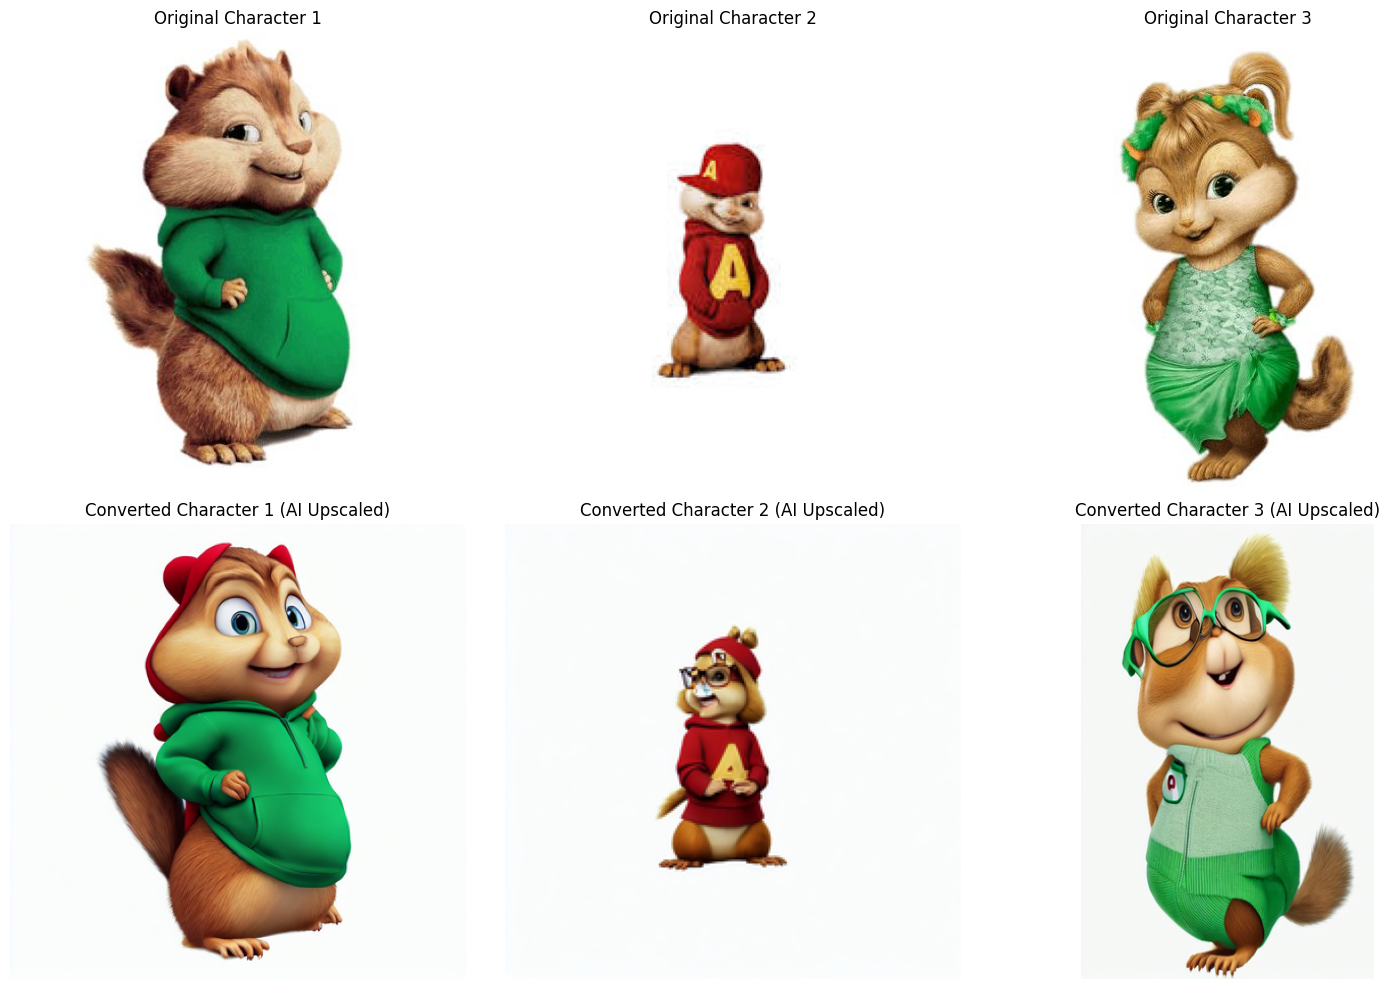

In [8]:
# Define prompts for each character - keeping original Alvin and the Chipmunks style
character_prompts = [
    "alvin and the chipmunks character, alvin, red hoodie, mischievous, cartoon style, high quality, detailed, sharp, crisp, clear eyes, transparent background",
    "alvin and the chipmunks character, simon, blue sweater, glasses, smart, cartoon style, high quality, detailed, sharp, crisp, clear eyes, transparent background", 
    "alvin and the chipmunks character, theodore, green sweater, chubby, cute, cartoon style, high quality, detailed, sharp, crisp, clear eyes with glasses, transparent background"
]

# Convert each character with built-in AI upscaling
print("Converting characters with img2img + automatic AI upscaling...")
converted_characters = []

for i, (character_img, prompt) in enumerate(zip([ch1, ch2, ch3], character_prompts)):
    print(f"Converting character {i+1}...")
    
    # Convert with automatic AI upscaling built into the function
    converted = convert_character_with_img2img(
        img2img_pipe, character_img, prompt, 
        strength=0.65,  # Slightly higher to maintain character features
        guidance_scale=8.5,  # Higher guidance for better prompt adherence
        seed=42 + i,
        apply_ai_upscaling=True  # Enable automatic AI upscaling
    )
    
    converted_characters.append(converted)

# Display converted characters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original characters
for i, char in enumerate([ch1, ch2, ch3]):
    axes[0, i].imshow(char)
    axes[0, i].set_title(f"Original Character {i+1}")
    axes[0, i].axis('off')

# Converted characters (automatically AI upscaled)
for i, char in enumerate(converted_characters):
    axes[1, i].imshow(char)
    axes[1, i].set_title(f"Converted Character {i+1} (AI Upscaled)")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Converting fantasy characters with img2img + automatic AI upscaling...
Converting character 1...


  0%|          | 0/21 [00:00<?, ?it/s]

  Applying AI upscaling to generated image...
Converting character 2...


  0%|          | 0/21 [00:00<?, ?it/s]

  Applying AI upscaling to generated image...
Converting character 3...


  0%|          | 0/21 [00:00<?, ?it/s]

  Applying AI upscaling to generated image...


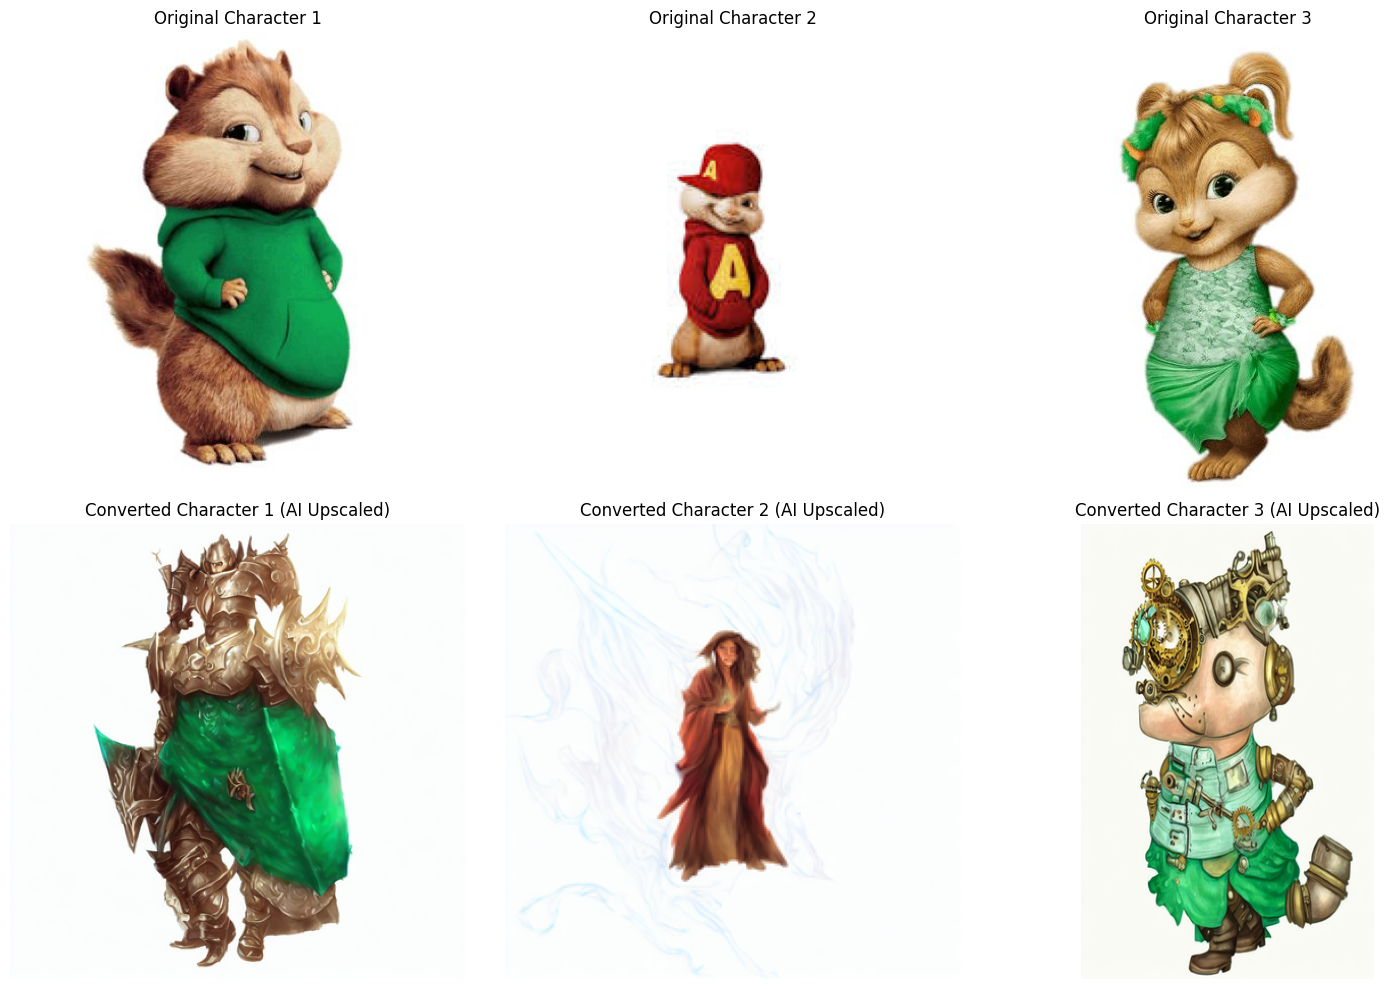

In [9]:
# Define prompts for each character
character_prompts = [
    "fantasy warrior character, detailed armor, heroic pose, high quality, detailed",
    "magical wizard character, flowing robes, mystical aura, fantasy art style, detailed",
    "steampunk adventurer character, mechanical parts, Victorian style, detailed"
]

# Convert each character with built-in AI upscaling
print("Converting fantasy characters with img2img + automatic AI upscaling...")
converted_characters = []

for i, (character_img, prompt) in enumerate(zip([ch1, ch2, ch3], character_prompts)):
    print(f"Converting character {i+1}...")
    converted = convert_character_with_img2img(
        img2img_pipe, character_img, prompt, 
        strength=0.7, guidance_scale=7.5, seed=42 + i,
        apply_ai_upscaling=True  # Enable automatic AI upscaling
    )
    converted_characters.append(converted)

# Display converted characters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original characters
for i, char in enumerate([ch1, ch2, ch3]):
    axes[0, i].imshow(char)
    axes[0, i].set_title(f"Original Character {i+1}")
    axes[0, i].axis('off')

# Converted characters (automatically AI upscaled)
for i, char in enumerate(converted_characters):
    axes[1, i].imshow(char)
    axes[1, i].set_title(f"Converted Character {i+1} (AI Upscaled)")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Integrating converted characters into the scene with AI upscaling...
Integrating character 1...


  0%|          | 0/20 [00:00<?, ?it/s]

  Applying AI upscaling to inpainted character 1...
Integrating character 2...


  0%|          | 0/20 [00:00<?, ?it/s]

  Applying AI upscaling to inpainted character 2...
Integrating character 3...


  0%|          | 0/20 [00:00<?, ?it/s]

  Applying AI upscaling to inpainted character 3...


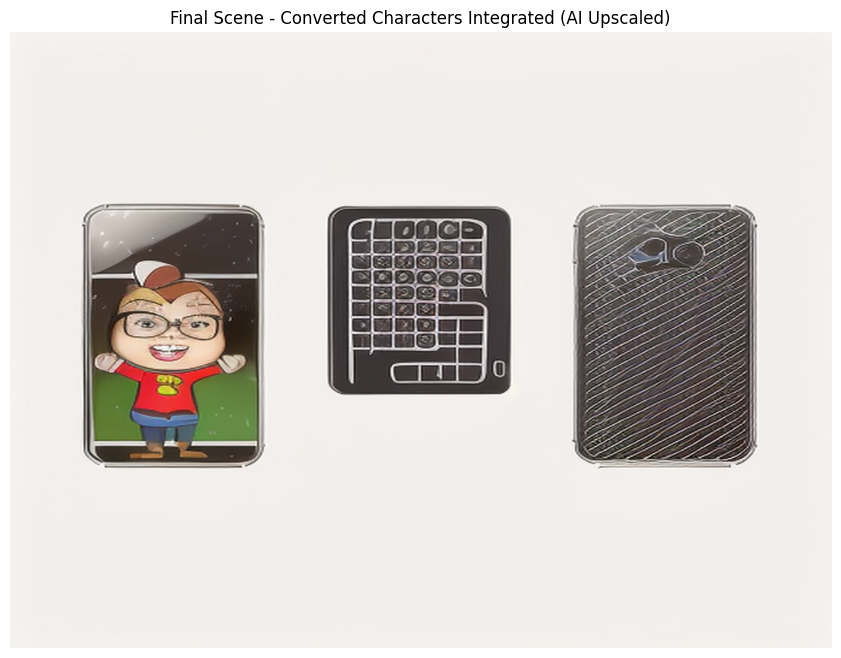

In [10]:
def integrate_characters_with_inpainting(canvas: Image.Image, char_bboxes: List[Tuple[int, int, int, int]], 
                                        converted_characters: List[Image.Image], 
                                        inpaint_pipe, apply_ai_upscaling: bool = True) -> Image.Image:
    """Integrate converted characters into the scene using inpainting with AI upscaling."""
    
    result = canvas.copy()
    
    for i, (bbox, converted_char) in enumerate(zip(char_bboxes, converted_characters)):
        print(f"Integrating character {i+1}...")
        
        # Create mask for this character area
        mask = create_mask_for_character(result, bbox, feather_radius=15)
        
        # Resize converted character to fit the bbox
        char_width = bbox[2] - bbox[0]
        char_height = bbox[3] - bbox[1]
        char_resized = resize_image_maintain_aspect(converted_char, (char_width, char_height))
        
        # Create a temporary image with the character placed
        temp_image = result.copy()
        temp_image.paste(char_resized, (bbox[0], bbox[1]), char_resized)
        
        # Use inpainting to blend the character seamlessly
        torch.manual_seed(42 + i)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42 + i)
        
        # Resize for processing
        process_size = (512, 512)
        image_resized = temp_image.resize(process_size, Image.Resampling.LANCZOS)
        mask_resized = mask.resize(process_size, Image.Resampling.LANCZOS)
        
        with torch.no_grad():
            inpaint_result = inpaint_pipe(
                prompt=f"alvin and the chipmunks character, cartoon style, clean background, high quality, detailed",
                image=image_resized,
                mask_image=mask_resized,
                negative_prompt="blurry, low quality, distorted, artifacts, realistic, human, abstract",
                num_inference_steps=20,
                guidance_scale=7.5
            )
        
        # Get the inpainted image
        inpainted_image = inpaint_result.images[0]
        
        # Apply AI upscaling to the inpainted result for better quality
        if apply_ai_upscaling:
            print(f"  Applying AI upscaling to inpainted character {i+1}...")
            inpainted_image = upscale_image(inpainted_image, scale_factor=1.5, use_ai=True)
        
        # Resize back and update result
        inpainted_image = inpainted_image.resize(result.size, Image.Resampling.LANCZOS)
        result = inpainted_image
    
    return result

# Integrate characters into the scene with AI upscaling
print("Integrating converted characters into the scene with AI upscaling...")
final_scene = integrate_characters_with_inpainting(canvas, char_bboxes, converted_characters, inpaint_pipe, apply_ai_upscaling=True)

# Display the final result
plt.figure(figsize=(12, 8))
plt.imshow(final_scene)
plt.title("Final Scene - Converted Characters Integrated (AI Upscaled)")
plt.axis('off')
plt.show()

Integrating converted characters into the scene with AI upscaling...
Integrating character 1...


  0%|          | 0/20 [00:00<?, ?it/s]

  Applying AI upscaling to inpainted character 1...
Integrating character 2...


  0%|          | 0/20 [00:00<?, ?it/s]

  Applying AI upscaling to inpainted character 2...
Integrating character 3...


  0%|          | 0/20 [00:00<?, ?it/s]

  Applying AI upscaling to inpainted character 3...


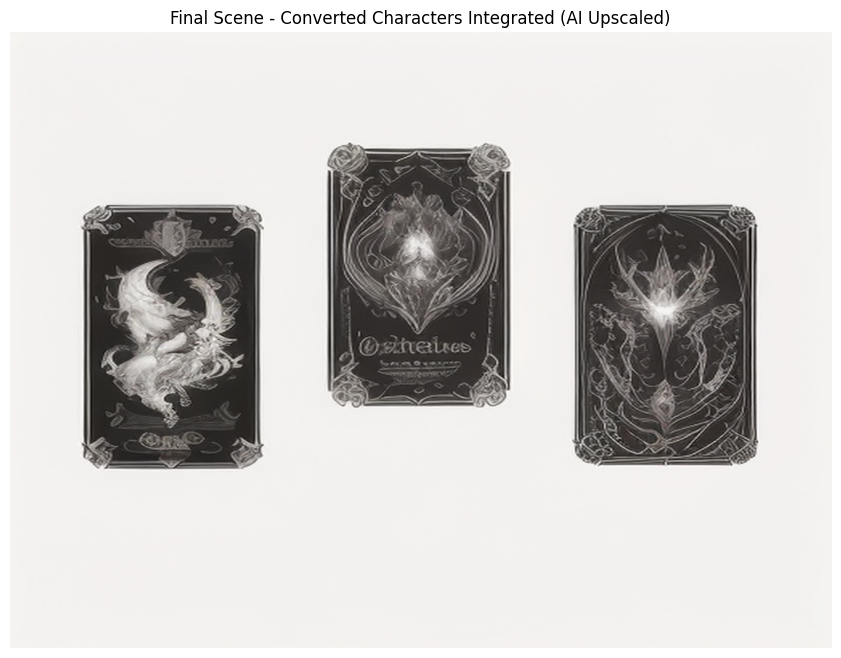

In [11]:
def integrate_characters_with_inpainting(canvas: Image.Image, char_bboxes: List[Tuple[int, int, int, int]], 
                                        converted_characters: List[Image.Image], 
                                        inpaint_pipe, apply_ai_upscaling: bool = True) -> Image.Image:
    """Integrate converted characters into the scene using inpainting with AI upscaling."""
    
    result = canvas.copy()
    
    for i, (bbox, converted_char) in enumerate(zip(char_bboxes, converted_characters)):
        print(f"Integrating character {i+1}...")
        
        # Create mask for this character area
        mask = create_mask_for_character(result, bbox, feather_radius=15)
        
        # Resize converted character to fit the bbox
        char_width = bbox[2] - bbox[0]
        char_height = bbox[3] - bbox[1]
        char_resized = resize_image_maintain_aspect(converted_char, (char_width, char_height))
        
        # Create a temporary image with the character placed
        temp_image = result.copy()
        temp_image.paste(char_resized, (bbox[0], bbox[1]), char_resized)
        
        # Use inpainting to blend the character seamlessly
        torch.manual_seed(42 + i)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42 + i)
        
        # Resize for processing
        process_size = (512, 512)
        image_resized = temp_image.resize(process_size, Image.Resampling.LANCZOS)
        mask_resized = mask.resize(process_size, Image.Resampling.LANCZOS)
        
        with torch.no_grad():
            inpaint_result = inpaint_pipe(
                prompt=f"seamlessly integrated character, high quality, detailed, fantasy art style",
                image=image_resized,
                mask_image=mask_resized,
                negative_prompt="blurry, low quality, distorted, artifacts",
                num_inference_steps=20,
                guidance_scale=7.5
            )
        
        # Get the inpainted image
        inpainted_image = inpaint_result.images[0]
        
        # Apply AI upscaling to the inpainted result for better quality
        if apply_ai_upscaling:
            print(f"  Applying AI upscaling to inpainted character {i+1}...")
            inpainted_image = upscale_image(inpainted_image, scale_factor=1.5, use_ai=True)
        
        # Resize back and update result
        inpainted_image = inpainted_image.resize(result.size, Image.Resampling.LANCZOS)
        result = inpainted_image
    
    return result

# Integrate characters into the scene with AI upscaling
print("Integrating converted characters into the scene with AI upscaling...")
final_scene = integrate_characters_with_inpainting(canvas, char_bboxes, converted_characters, inpaint_pipe, apply_ai_upscaling=True)

# Display the final result
plt.figure(figsize=(12, 8))
plt.imshow(final_scene)
plt.title("Final Scene - Converted Characters Integrated (AI Upscaled)")
plt.axis('off')
plt.show()

## Display Final Results

Final Results Generated Successfully!
All images are displayed in the notebook above.


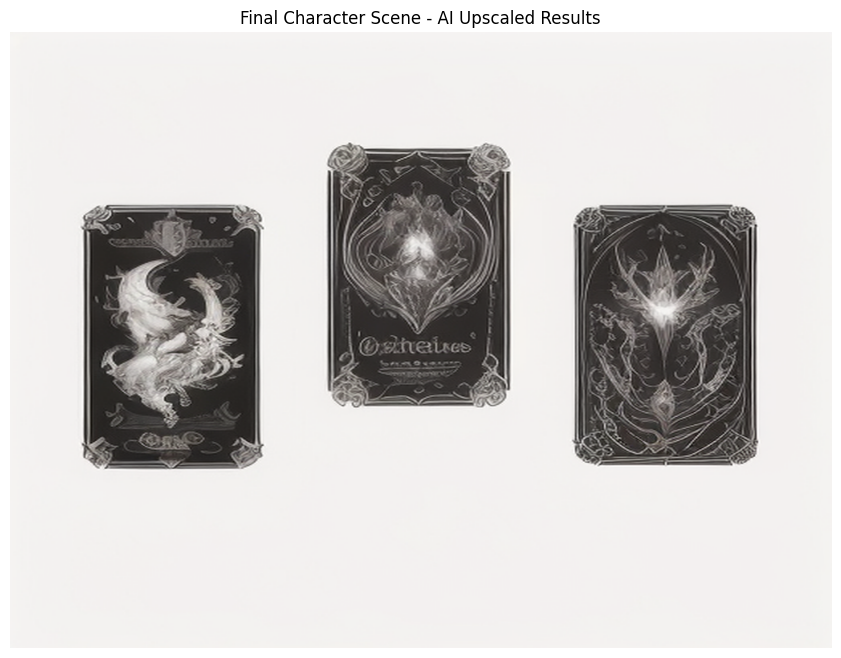

✅ All processing complete! Images are displayed in the notebook.


In [12]:
# Display final results (no local saving)
print("Final Results Generated Successfully!")
print("All images are displayed in the notebook above.")

# Display final result
plt.figure(figsize=(12, 8))
plt.imshow(final_scene)
plt.title("Final Character Scene - AI Upscaled Results")
plt.axis('off')
plt.show()

print("✅ All processing complete! Images are displayed in the notebook.")

## Experiment with Different Character Styles

You can experiment with different prompts to achieve different character styles:

In [13]:
# Alternative AI upscaling models you can experiment with
UPSCALING_MODELS = {
    "swin2sr": "caidas/swin2SR-realworld-sr-x4-64-bsrgan-psnr",  # Best for real-world images
    "esrgan": "ai-forever/Real-ESRGAN",  # Good for anime/cartoon
    "swinir": "jingyunliang/SwinIR",  # Good general purpose
    "hinet": "xinntao/HINet",  # Fast upscaling
}

def setup_ai_upscaler_advanced(model_name="swin2sr"):
    """Setup AI upscaler with different model options."""
    if not AI_UPSCALING_AVAILABLE:
        return None, None
    
    try:
        model_path = UPSCALING_MODELS[model_name]
        print(f"Loading AI upscaling model: {model_path}")
        
        processor = AutoImageProcessor.from_pretrained(model_path)
        model = AutoModelForImage2Image.from_pretrained(model_path)
        model.to(device)
        
        print(f"✅ AI upscaling model ({model_name}) loaded successfully!")
        return processor, model
    except Exception as e:
        print(f"⚠️ Failed to load AI upscaling model ({model_name}): {e}")
        return None, None

# Example: Try different upscaling models
print("Available AI upscaling models:")
for name, path in UPSCALING_MODELS.items():
    print(f"  - {name}: {path}")

# You can test different models by changing the model_name parameter
# Example: setup_ai_upscaler_advanced("esrgan") for anime-style upscaling

Available AI upscaling models:
  - swin2sr: caidas/swin2SR-realworld-sr-x4-64-bsrgan-psnr
  - esrgan: ai-forever/Real-ESRGAN
  - swinir: jingyunliang/SwinIR
  - hinet: xinntao/HINet
